#### Preparing data
Run the next cells to download and prepare the datasets and util functions.

In [1]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [2]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=True)

In [3]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

In [4]:
if download_data:
    unzip_leaf_dataset()

#### Notebook start

In [5]:
import os
import local.lib as lib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from init import dataset_dir
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input, Conv2D,Flatten, LeakyReLU, ReLU, BatchNormalization
from tensorflow.keras.backend import clear_session

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

# Multimodal arquitecture


In [6]:
split=0.7

In [7]:
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=dataset_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


#### target onehot

In [8]:
y_train_oh = np.eye(num_classes)[y_train]
y_test_oh  = np.eye(num_classes)[y_test]

In [9]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))
X_test_ri = X_test_ri.reshape((X_test_ri.shape[0], X_test_ri.shape[1], X_test_ri.shape[2], 1))

In [10]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((693, 194), (693, 128, 128, 1), (693, 99))

In [11]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((297, 194), (297, 128, 128, 1), (297, 99))

## Models

In [0]:
def model_OD1(input_dim, extra_info_dim, num_classes):
    
    clear_session()
    inp1 = Input(shape=(input_dim[1],input_dim[2],1))
    l11 = Conv2D(16, (7,7))(inp1)
    acv1 = ReLU()(l11)
    l12 = Flatten()(acv1)

    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l12, inp2], axis=1)
    
    l13 =  Dense(256)(cc1)
    acv2 = ReLU()(l13)
       
    output = Dense(num_classes, activation='softmax')(acv2)
  
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])
    model.reset_states()
    
    return model



In [0]:
model = model_OD1(input_dim=X_train_ri.shape, extra_info_dim=X_train_f.shape[1], num_classes=num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 122, 122, 16) 800         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 122, 122, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 238144)       0           re_lu[0][0]                      
______________________________________________________________________________________________

In [0]:
history = model.fit([X_train_ri, X_train_f], y_train_oh, epochs=5, batch_size=20)

Epoch 1/5
35/35 [==============================] - 23s 667ms/step - loss: 14.5306 - accuracy: 0.0678
Epoch 2/5
35/35 [==============================] - 23s 662ms/step - loss: 1.8371 - accuracy: 0.5815
Epoch 3/5
35/35 [==============================] - 23s 660ms/step - loss: 0.4905 - accuracy: 0.8802
Epoch 4/5
35/35 [==============================] - 23s 664ms/step - loss: 0.0738 - accuracy: 0.9856
Epoch 5/5
35/35 [==============================] - 23s 665ms/step - loss: 0.0430 - accuracy: 0.9899


Text(0.5, 1.0, 'Train performance')

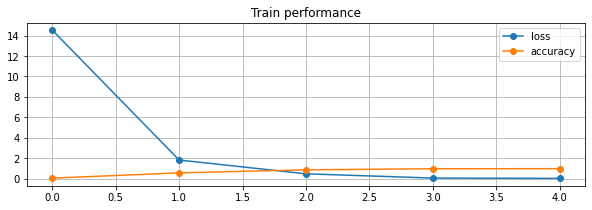

In [0]:
plt.figure(figsize=(10,3))
plt.plot(history.history["loss"], label="loss", marker="o")
plt.plot(history.history["accuracy"], label="accuracy", marker="o")
plt.grid()
plt.legend()
plt.title("Train performance")

In [0]:
preds_train = model.predict([X_train_ri, X_train_f]).argmax(axis=1)
preds_test = model.predict([X_test_ri, X_test_f]).argmax(axis=1)

print("train accuracy {}".format((preds_train == y_train).mean()))
print("test accuracy  {}".format((preds_test == y_test).mean()))

train accuracy 0.976911976911977
test accuracy  0.4006734006734007


Text(0, 0.5, 'y_pred')

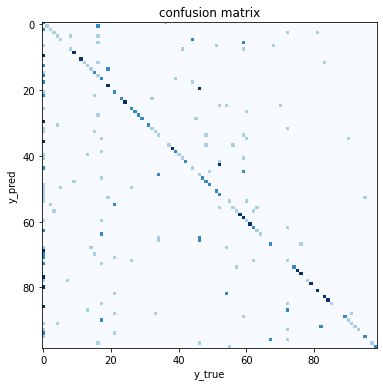

In [0]:
cm = confusion_matrix(y_pred=preds_test, y_true=y_test)

plt.figure(figsize=(6,6))
plt.imshow(cm, aspect="auto", cmap="Blues")
plt.title("confusion matrix")
plt.xlabel("y_true")
plt.ylabel("y_pred")

## Increase convolutional complexity

In [0]:
def model_OD2(input_dim, extra_info_dim, num_classes):
    
    clear_session()
    inp1 = Input(shape=(input_dim[1],input_dim[2],1))
    l11 = Conv2D(64, (7,7))(inp1)
    acv1 = LeakyReLU()(l11)
    
    l12 = Conv2D(32, (7,7))(acv1)
    acv2 = LeakyReLU()(l12)

    l13 = Flatten()(acv2)

    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l13, inp2], axis=1)
    
    l14 =  Dense(256, activation="relu")(cc1)
    acv2 = ReLU()(l14)
       
    output = Dense(num_classes, activation='softmax')(acv2)
  
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])
    model.reset_states()
    
    return model



Building onehot target ... ok
Reshaping image ... ok
Training model ... ok
Checking results ...
train accuracy 0.07503607503607504
test accuracy  0.05723905723905724
CPU times: user 38min 12s, sys: 17.6 s, total: 38min 30s
Wall time: 19min 43s


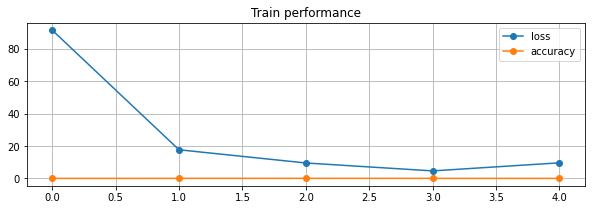

In [0]:
%%time
lib.multimodal_experiment(get_model=model_OD2, img_X_train=X_train_ri, fea_X_train=X_train_f, img_X_test=X_test_ri,
                          fea_X_test=X_test_f, y_train=y_train, y_test=y_test, num_classes=num_classes, verbose=0, epochs=5, batch_size=20)

## Increase dense complexity

In [0]:
def model_OD3(input_dim, extra_info_dim, num_classes):
    
    clear_session()
    inp1 = Input(shape=(input_dim[1],input_dim[2],1))
    l11 = Conv2D(16, (7, 7))(inp1)
    acv1 = ReLU()(l11)
    l12 = Flatten()(acv1)

    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l12, inp2], axis=1)
    
    l13 =  Dense(256)(cc1)
    acv2 = LeakyReLU()(l13)
    drop1 = Dropout(0.5)(acv2)

    l14 =  Dense(128)(drop1)
    acv3 = LeakyReLU()(l14)
    drop2 = Dropout(0.5)(acv3)
       
    output = Dense(num_classes, activation='softmax')(drop2)
  
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])
    model.reset_states()
    
    return model



Building onehot target ... ok
Reshaping image ... ok
Training model ... ok
Checking results ...
train accuracy 0.9942279942279942
test accuracy  0.45791245791245794
CPU times: user 4min 6s, sys: 4.43 s, total: 4min 10s
Wall time: 2min 8s


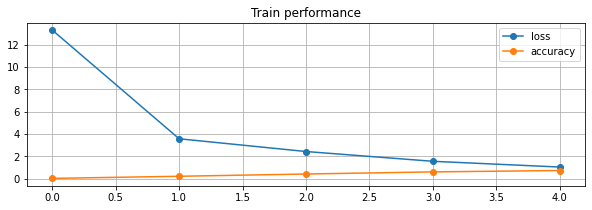

In [200]:
%%time
lib.multimodal_experiment(get_model=model_OD3, img_X_train=X_train_ri, fea_X_train=X_train_f, img_X_test=X_test_ri,
                          fea_X_test=X_test_f, y_train=y_train, y_test=y_test, num_classes=num_classes, verbose=0, epochs=5, batch_size=20)